In [2]:
from torch.utils.data import DataLoader
from torch import optim 
import torch.nn as nn
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from loader import cityscapesDataset
from models import unet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [93]:
cd = cityscapesDataset.CityscapesDataset("./data", split='train', target_type='semantic',
                               shrinkToSize=10, cropHeight=512, cropWidth=1024)
cd2 = cityscapesDataset.CityscapesDataset("./data", split='val', target_type='semantic', shrinkToSize=10)
# learner = unet.UNet(3, cd.n_classes).to(device=device)
learner = unet.UNet(3, cd.n_classes)

In [6]:
bs = 1
n_workers=4
n_epochs = 5
lr = 0.0003
mom=0.9# Not used
wd = 0.01

In [94]:
dl_train = DataLoader(cd, batch_size=bs, num_workers=n_workers, pin_memory=True, shuffle=True)
dataiter = iter(dl_train)

dl_val = DataLoader(cd2, batch_size=bs, num_workers=n_workers, pin_memory=True, shuffle=True)

In [7]:
# cd_test = cityscapesDataset.CityscapesDataset("./data", split='train', target_type='color',
#                                shrinkToSize=1, cropHeight=128, cropWidth=256)

In [8]:
img, col = cd_test[0]
print(img.shape)
print(col.shape)

torch.Size([3, 128, 256])
torch.Size([4, 128, 256])


In [ ]:
plt.imshow(img)
plt.show()

In [9]:
type(img)

torch.Tensor

In [10]:
cd.class_map

{7: 0,
 8: 1,
 11: 2,
 12: 3,
 13: 4,
 17: 5,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 31: 16,
 32: 17,
 33: 18}

In [7]:
# labels = cd.encode_segmap(labels)

In [11]:
np.unique(labels)

array([ 0,  1,  2,  4, 11, 13], dtype=int64)

In [6]:
optimizer = optim.Adam(learner.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss(ignore_index=cd.ignore_index)

In [7]:
# help from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
losses_tr=[]
losses_val=[]
for epoch in tqdm(range(n_epochs)):
    learner.train()
    train_epoch_loss = 0
    val_epoch_loss=0
    for imgs, lbls in dl_train:
        
        imgs = imgs.to(device=device)
        lbls = lbls.to(device=device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        #forward
        pred = learner(imgs)
        
        #shrink labels for nn.CrossEntropy
        lbls = lbls.squeeze(dim=1)
        loss = criterion(pred, lbls)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
 
    with torch.no_grad():
        learner.eval()
        for imgs, lbls in dl_val:

            imgs = imgs.to(device=device)
            lbls = lbls.to(device=device)

            pred = learner(imgs)
            lbls = lbls.squeeze(dim=1)
            loss = criterion(pred, lbls)
            val_epoch_loss+=loss.item()
        
    losses_tr.append(train_epoch_loss)
    losses_val.append(val_epoch_loss)
    
    print("Epoch {}, Train Loss: {}, Val Loss: {}".format(epoch, train_epoch_loss, val_epoch_loss))
    

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 3.00 GiB total capacity; 2.04 GiB already allocated; 30.91 MiB free; 2.08 GiB reserved in total by PyTorch)

In [30]:
test = torch.ones([1, 5, 2, 2])
test

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])

In [25]:
res = test.argmax(dim=1)
res

tensor([[[0, 4],
         [3, 4]]])

In [31]:
test[test==1].shape

torch.Size([20])

In [56]:
import numpy as np


In [95]:
checkpoint = torch.load("save90.pth")
learner.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
startEpoch = checkpoint['epoch']
# loss = checkpoint['loss']
print("Epoch ",startEpoch," Loaded.")

Epoch  90  Loaded.


In [96]:
images, labels = dataiter.next()
print(labels.shape)
labels = labels.squeeze(dim=1)
print(labels.shape)

torch.Size([1, 1, 512, 1024])
torch.Size([1, 512, 1024])


In [97]:
# images = images.to(device=device)
# labels = labels.to(device=device)
        
pred = learner(images)

In [98]:
print(images.shape)
print(labels.shape)
print(pred.shape)

torch.Size([1, 3, 512, 1024])
torch.Size([1, 512, 1024])
torch.Size([1, 19, 512, 1024])


In [99]:
pred_flat = pred.argmax(dim=1)
pred_flat.shape

torch.Size([1, 512, 1024])

In [100]:
print(np.unique(pred_flat))
print(np.unique(labels))

[ 0  2  8 10]
[-1  0  1  2  5  6  7  9 13]


In [101]:
colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(19), colors))


In [102]:
def decode_segmap(mask):
    
    r = mask.copy()
    g = mask.copy()
    b = mask.copy()
    
    for cls in range(0, 19): #change
        r[mask==cls] = label_colours[cls][0]
        g[mask==cls] = label_colours[cls][1]
        b[mask==cls] = label_colours[cls][2]
    
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    
    return rgb

In [103]:
res = decode_segmap(pred_flat.numpy()[0])
res.shape

(512, 1024, 3)

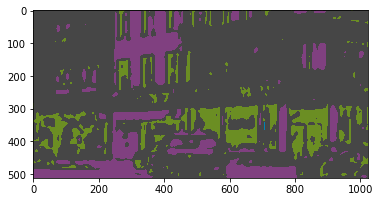

In [104]:
fig, ax = plt.subplots(1,1,)
ax.imshow(res)
plt.show()

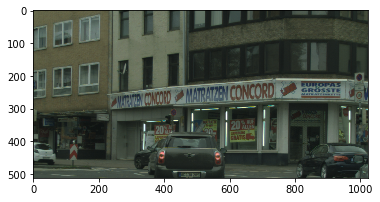

In [105]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.transpose(images[0], [1,2,0]))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


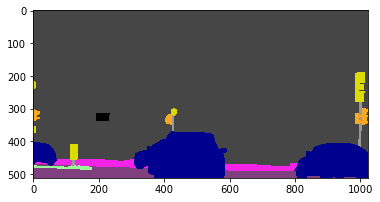

In [106]:
lbl_mp = decode_segmap(labels.numpy()[0])

fig, ax = plt.subplots(1,1)
ax.imshow(lbl_mp)
plt.show()